In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [2]:
power = pd.read_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/power_data.txt",names=["power_demand"])


In [3]:
sub_power = pd.Series(power[490:51*84*8+490].reset_index(drop=True)["power_demand"])
sub_power = sub_power[::8].reset_index(drop=True)
sub_power = sub_power.reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(sub_power)
sub_power = scaler.transform(sub_power) 

sub_power_ = np.array([sub_power[t][0] for t in range(sub_power.shape[0])])
sub_power_list = [sub_power_[t*84:(t+1)*84] for t in range(51)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
anomalous_indices = [11,12,16,17,19,50]
normal_indices = list(set(range(51))-set(anomalous_indices))
dataset_normal = [sub_power_list[i] for i in normal_indices]
dataset_anomalous = [sub_power_list[j] for j in anomalous_indices]

In [5]:
label = np.array(['anomaly' for _ in range(51)])
label[normal_indices] = 'normal'
label = [[x]*84 for x in label]
label = np.array(label).ravel()

In [6]:
sub_power.shape

(4284, 1)

In [7]:
data = pd.concat((pd.DataFrame(sub_power),pd.Series(label)),axis=1)

In [8]:
#data.to_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/power_data_labeled_unscaled.csv",header=None,index=None)

In [9]:
test_set = data[1008:]


# Autoencoder anomaly detection

In [10]:

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

## Reload power_demand autoencoder from disk

In [11]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try1_2_40_84/"
modelmeta_p = modelpath_root + "LSTMAutoencoder_power_2_40_84_para.ckpt.meta"
step_num = 84
hidden_num = 40
batch_num = 2
elem_num = 1

In [12]:
test_set_list = [test_set.iloc[:3192,0].as_matrix().reshape(19,2,84,1)[a] for a in range(19)]

In [13]:
sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
#        p_is_training = tf.placeholder(tf.bool)
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try1_2_40_84/LSTMAutoencoder_power_2_40_84_para.ckpt


# Without retraining

In [14]:
input_buffer = []
output_buffer = []
for data in test_set_list:
    (input_n, output_n) = sess.run([input_, output_], {p_input: data, p_is_training: False})
    input_buffer.append(input_n)
    output_buffer.append(output_n)

In [15]:
foo = pd.Series(np.array(input_buffer).ravel())
bar = pd.Series(np.array(output_buffer).ravel())
foobar = pd.concat((foo,bar),axis=1)

foobar.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/pred_without_retraining.csv",header=['input','output'],index=None)

Text(0.5,1,'Without retraining: batch_num=2, #hidden layer units=40, time_steps=84')

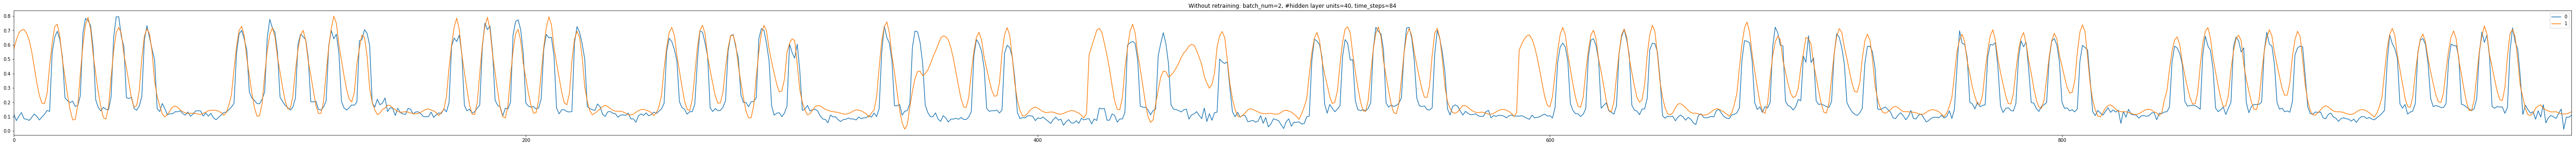

In [16]:
foobar[:1000].plot(figsize=(100,5))

plt.title("Without retraining: batch_num=2, #hidden layer units=40, time_steps=84")

In [76]:
#foobar = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/without_retraining(point).csv")

Normal: Max 0.40, min 0.00, avg 0.08, median 0.05
Abnormal: Max 0.63, min 0.00, avg 0.15, median 0.08


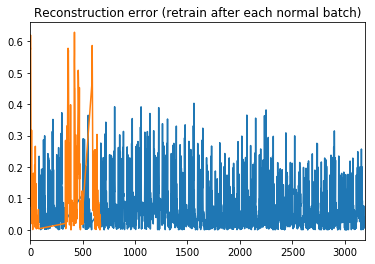

In [80]:
# reconstruction error (without retraining)

normal =pd.DataFrame( foobar[label[1008:1008+3192]== 'normal'])
abnormal =pd.DataFrame( foobar[label[1008:1008+3192]== 'anomaly'])

error1 = abs( normal['input']- normal['output'])
error2 = abs( abnormal['input']- abnormal['output'])
error1.plot()
error2.plot()
plt.title("Reconstruction error (retrain after each normal batch)")
print("Normal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error1),min(error1), np.mean(error1),np.median(error1)))
print("Abnormal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error2),min(error2), np.mean(error2),np.median(error2)))

In [81]:
# statistical results in batch
normal_batches = [error1[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error1.size//(batch_num*step_num))]
abnormal_batches = [error2[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error2.size//(batch_num*step_num))]

batch_error1  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in normal_batches])
batch_error2  = pd.DataFrame([[max(y),min(y),np.mean(y),np.median(y)] for y in abnormal_batches])

batch_error1.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/normal_without_retraining(batch).csv",header=['max','min','avg','median'],index=None)
batch_error2.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/abnormal_without_retraining(batch).csv",header=['max','min','avg','median'],index=None)


# Retrain after each (normal) batch (Continue training)

Retrain-iter 1: 0.0116806
Retrain-iter 2: 0.0102842
Retrain-iter 3: 0.00846893
Retrain-iter 4: 0.00735787
Retrain-iter 5: 0.00688914
Retrain-iter 6: 0.00698665
Retrain-iter 7: 0.0074963
Retrain-iter 8: 0.00800158
Retrain-iter 9: 0.00809447
Retrain-iter 10: 0.00772963
Retrain-iter 11: 0.00717266
Retrain-iter 12: 0.00668357
Retrain-iter 13: 0.00642023
Retrain-iter 14: 0.00647043
Retrain-iter 15: 0.00674952
Retrain-iter 16: 0.00699783
Retrain-iter 17: 0.00701476
Retrain-iter 18: 0.00681899
Retrain-iter 19: 0.00655404
Retrain-iter 20: 0.00633931
Retrain-iter 21: 0.00623462
Retrain-iter 22: 0.00625287
Retrain-iter 23: 0.00634571
Retrain-iter 24: 0.00641783
Retrain-iter 25: 0.00640394
Retrain-iter 26: 0.00631793
Retrain-iter 27: 0.00621512
Retrain-iter 28: 0.00613706
Retrain-iter 29: 0.00610113
Retrain-iter 30: 0.00610816
Retrain-iter 31: 0.00613574
Retrain-iter 32: 0.00614356
Retrain-iter 33: 0.00611219
Retrain-iter 34: 0.00606166
Retrain-iter 35: 0.00601795
Retrain-iter 36: 0.00598876
Retr

Retrain-iter 96: 0.00382219
Retrain-iter 97: 0.00381836
Retrain-iter 98: 0.00381452
Retrain-iter 99: 0.00381067
Retrain-iter 100: 0.00380682
Retrain-iter 1: 0.0055834
Retrain-iter 2: 0.00495048
Retrain-iter 3: 0.00442524
Retrain-iter 4: 0.0041392
Retrain-iter 5: 0.00422084
Retrain-iter 6: 0.00448399
Retrain-iter 7: 0.0045682
Retrain-iter 8: 0.00451503
Retrain-iter 9: 0.00436053
Retrain-iter 10: 0.00415724
Retrain-iter 11: 0.00404088
Retrain-iter 12: 0.00405124
Retrain-iter 13: 0.00413301
Retrain-iter 14: 0.00418728
Retrain-iter 15: 0.00416487
Retrain-iter 16: 0.00409031
Retrain-iter 17: 0.00400392
Retrain-iter 18: 0.00396045
Retrain-iter 19: 0.00395791
Retrain-iter 20: 0.00395963
Retrain-iter 21: 0.00397029
Retrain-iter 22: 0.00397919
Retrain-iter 23: 0.00396351
Retrain-iter 24: 0.00394016
Retrain-iter 25: 0.00391283
Retrain-iter 26: 0.00387852
Retrain-iter 27: 0.00386704
Retrain-iter 28: 0.00387537
Retrain-iter 29: 0.00387829
Retrain-iter 30: 0.00387819
Retrain-iter 31: 0.00386962
Ret

Retrain-iter 92: 0.00190655
Retrain-iter 93: 0.00189726
Retrain-iter 94: 0.00188841
Retrain-iter 95: 0.00187999
Retrain-iter 96: 0.00187197
Retrain-iter 97: 0.00186434
Retrain-iter 98: 0.00185704
Retrain-iter 99: 0.00185001
Retrain-iter 100: 0.00184315
Retrain-iter 1: 0.00168736
Retrain-iter 2: 0.00158927
Retrain-iter 3: 0.00164403
Retrain-iter 4: 0.00158031
Retrain-iter 5: 0.00160808
Retrain-iter 6: 0.00156747
Retrain-iter 7: 0.00155093
Retrain-iter 8: 0.00156002
Retrain-iter 9: 0.00153211
Retrain-iter 10: 0.00152894
Retrain-iter 11: 0.00149197
Retrain-iter 12: 0.00150591
Retrain-iter 13: 0.00148749
Retrain-iter 14: 0.00147388
Retrain-iter 15: 0.0014681
Retrain-iter 16: 0.00145353
Retrain-iter 17: 0.00145976
Retrain-iter 18: 0.00143546
Retrain-iter 19: 0.00143644
Retrain-iter 20: 0.00142763
Retrain-iter 21: 0.00142025
Retrain-iter 22: 0.00142084
Retrain-iter 23: 0.00140329
Retrain-iter 24: 0.00140791
Retrain-iter 25: 0.00139995
Retrain-iter 26: 0.0013924
Retrain-iter 27: 0.00138886
Re

Retrain-iter 89: 0.00153123
Retrain-iter 90: 0.00152961
Retrain-iter 91: 0.001528
Retrain-iter 92: 0.00152638
Retrain-iter 93: 0.00152477
Retrain-iter 94: 0.00152317
Retrain-iter 95: 0.00152157
Retrain-iter 96: 0.00151998
Retrain-iter 97: 0.00151839
Retrain-iter 98: 0.00151681
Retrain-iter 99: 0.00151523
Retrain-iter 100: 0.00151366
Retrain-iter 1: 0.00347333
Retrain-iter 2: 0.00322364
Retrain-iter 3: 0.00343454
Retrain-iter 4: 0.00322361
Retrain-iter 5: 0.00321092
Retrain-iter 6: 0.00328287
Retrain-iter 7: 0.00309814
Retrain-iter 8: 0.00319687
Retrain-iter 9: 0.00314124
Retrain-iter 10: 0.00306673
Retrain-iter 11: 0.00312687
Retrain-iter 12: 0.00304164
Retrain-iter 13: 0.0030419
Retrain-iter 14: 0.00305631
Retrain-iter 15: 0.00299695
Retrain-iter 16: 0.00300414
Retrain-iter 17: 0.00299251
Retrain-iter 18: 0.00296119
Retrain-iter 19: 0.00296422
Retrain-iter 20: 0.00295085
Retrain-iter 21: 0.0029297
Retrain-iter 22: 0.00292977
Retrain-iter 23: 0.00292102
Retrain-iter 24: 0.00290046
Retr

Retrain-iter 85: 0.00190765
Retrain-iter 86: 0.00190564
Retrain-iter 87: 0.00190374
Retrain-iter 88: 0.00190192
Retrain-iter 89: 0.00190002
Retrain-iter 90: 0.00189815
Retrain-iter 91: 0.00189636
Retrain-iter 92: 0.00189449
Retrain-iter 93: 0.00189262
Retrain-iter 94: 0.00189084
Retrain-iter 95: 0.00188902
Retrain-iter 96: 0.00188718
Retrain-iter 97: 0.00188542
Retrain-iter 98: 0.00188363
Retrain-iter 99: 0.00188183
Retrain-iter 100: 0.00188008
Retrain-iter 1: 0.00243901
Retrain-iter 2: 0.00188084
Retrain-iter 3: 0.00215036
Retrain-iter 4: 0.00217173
Retrain-iter 5: 0.00184754
Retrain-iter 6: 0.00195412
Retrain-iter 7: 0.00202701
Retrain-iter 8: 0.00180733
Retrain-iter 9: 0.00183959
Retrain-iter 10: 0.00196622
Retrain-iter 11: 0.00179813
Retrain-iter 12: 0.00173443
Retrain-iter 13: 0.00184466
Retrain-iter 14: 0.00175852
Retrain-iter 15: 0.00168999
Retrain-iter 16: 0.00175212
Retrain-iter 17: 0.00170285
Retrain-iter 18: 0.00164689
Retrain-iter 19: 0.00169786
Retrain-iter 20: 0.00167936


Retrain-iter 80: 0.00198544
Retrain-iter 81: 0.001983
Retrain-iter 82: 0.0019806
Retrain-iter 83: 0.00197822
Retrain-iter 84: 0.00197587
Retrain-iter 85: 0.00197355
Retrain-iter 86: 0.00197126
Retrain-iter 87: 0.00196901
Retrain-iter 88: 0.00196677
Retrain-iter 89: 0.00196456
Retrain-iter 90: 0.00196238
Retrain-iter 91: 0.00196022
Retrain-iter 92: 0.00195808
Retrain-iter 93: 0.00195597
Retrain-iter 94: 0.00195389
Retrain-iter 95: 0.00195183
Retrain-iter 96: 0.00194979
Retrain-iter 97: 0.00194777
Retrain-iter 98: 0.00194578
Retrain-iter 99: 0.0019438
Retrain-iter 100: 0.00194185


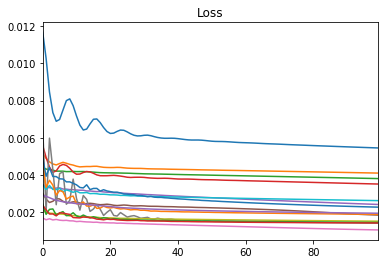

In [14]:
input_buffer = []
output_buffer = []
anomaly_batches = [0,2,3,18]
count = -1 # jump the anomaly batches, not used for retraining
loss_overall = []
for data in test_set_list:
    count +=1
    (input_n, output_n) = sess.run([input_, output_], {p_input: data, p_is_training: False})
    input_buffer.append(input_n)
    output_buffer.append(output_n)
    if count in anomaly_batches: 
        continue
    # retrain 
    loss = []
    for i in range(100):
        (loss_val, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
        loss.append(loss_val)
        print('Retrain-iter %d:' % (i + 1), loss_val)
    loss_overall.append(loss_val)
    pd.Series(loss).plot(title="Loss")

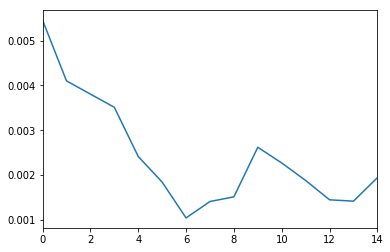

In [15]:
pd.Series(loss_overall).plot()

In [16]:
foo = pd.Series(np.array(input_buffer).ravel())
bar = pd.Series(np.array(output_buffer).ravel())
foobar = pd.concat((foo,bar),axis=1)

foobar.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retraining_after_each_normal_batch.csv",header=['input','output'],index=None)

Text(0.5,1,'Retraining after each batch: batch_num=2, #hidden layer units=40, time_steps=84')

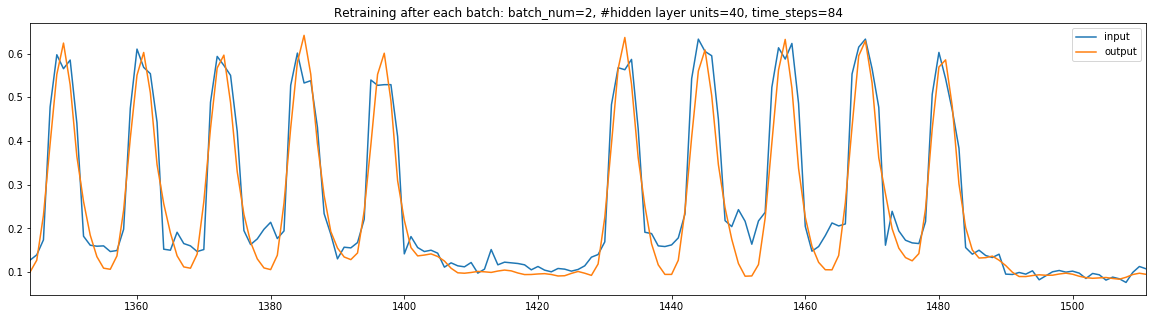

In [53]:
foobar[1344:1512].plot(figsize=(20,5))

plt.title("Retraining after each batch: batch_num=2, #hidden layer units=40, time_steps=84")

In [31]:
#foobar = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retraining_after_each_normal_batch(point).csv")

Normal: Max 0.39, min 0.00, avg 0.05, median 0.03
Abnormal: Max 0.62, min 0.00, avg 0.12, median 0.05


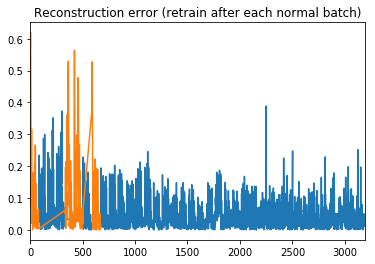

In [33]:
# reconstruction error of normal data(retrain after each batch)

normal =pd.DataFrame( foobar[label[1008:1008+3192]== 'normal'])
abnormal =pd.DataFrame( foobar[label[1008:1008+3192]== 'anomaly'])

error1 = abs( normal['input']- normal['output'])
error2 = abs( abnormal['input']- abnormal['output'])
error1.plot()
error2.plot()
plt.title("Reconstruction error (retrain after each normal batch)")
print("Normal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error1),min(error1), np.mean(error1),np.median(error1)))
print("Abnormal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error2),min(error2), np.mean(error2),np.median(error2)))

In [73]:
# statistical results in batch
normal_batches = [error1[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error1.size//(batch_num*step_num))]
abnormal_batches = [error2[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error2.size//(batch_num*step_num))]

batch_error1  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in normal_batches])
batch_error2  = pd.DataFrame([[max(y),min(y),np.mean(y),np.median(y)] for y in abnormal_batches])

batch_error1.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/normal_retraining(batch).csv",header=['max','min','avg','median'],index=None)
batch_error2.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/abnormal_retraining(batch).csv",header=['max','min','avg','median'],index=None)


# Analysis

In [82]:
# comparation of errors of the with- ad without-retraining models
with_error_n = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/normal_retraining(batch).csv")
with_error_a = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/abnormal_retraining(batch).csv")
without_error_n = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/normal_without_retraining(batch).csv")
without_error_a = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/abnormal_without_retraining(batch).csv")

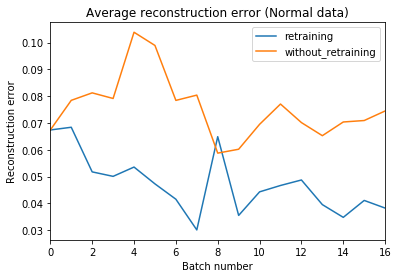

Text(0.5,1,'Average reconstruction error (Abnormal data)')

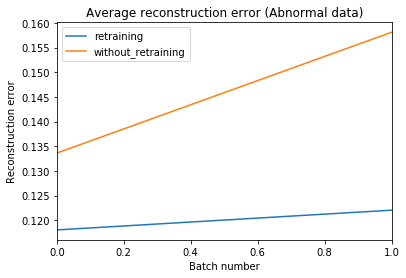

In [88]:
with_error_n['avg'].plot(label='retraining')
without_error_n['avg'].plot(label='without_retraining')
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Reconstruction error")
plt.title("Average reconstruction error (Normal data)")
plt.show()
plt.close()

with_error_a['avg'].plot(label='retraining')
without_error_a['avg'].plot(label='without_retraining')
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Reconstruction error")
plt.title("Average reconstruction error (Abnormal data)")

Text(0.5,1,'Median reconstruction error')

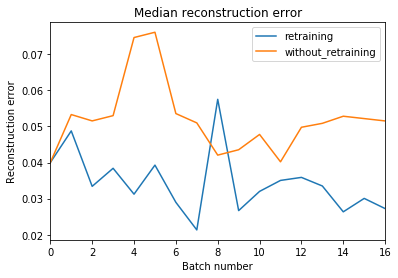

In [85]:
with_error_n['median'].plot(label='retraining')
without_error_n['median'].plot(label='without_retraining')
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Reconstruction error")
plt.title("Median reconstruction error")

Text(0.5,1,'Max reconstruction error')

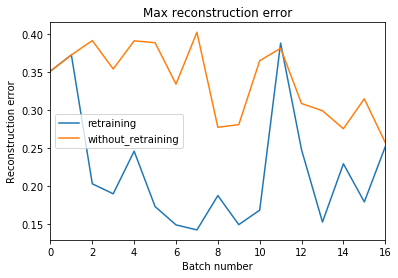

In [86]:
with_error_n['max'].plot(label='retraining')
without_error_n['max'].plot(label='without_retraining')
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Reconstruction error")
plt.title("Max reconstruction error")

Text(0.5,1,'Min reconstruction error')

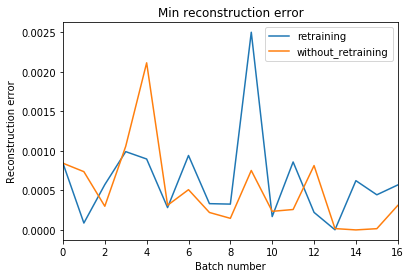

In [87]:
with_error_n['min'].plot(label='retraining')
without_error_n['min'].plot(label='without_retraining')
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Reconstruction error")
plt.title("Min reconstruction error")